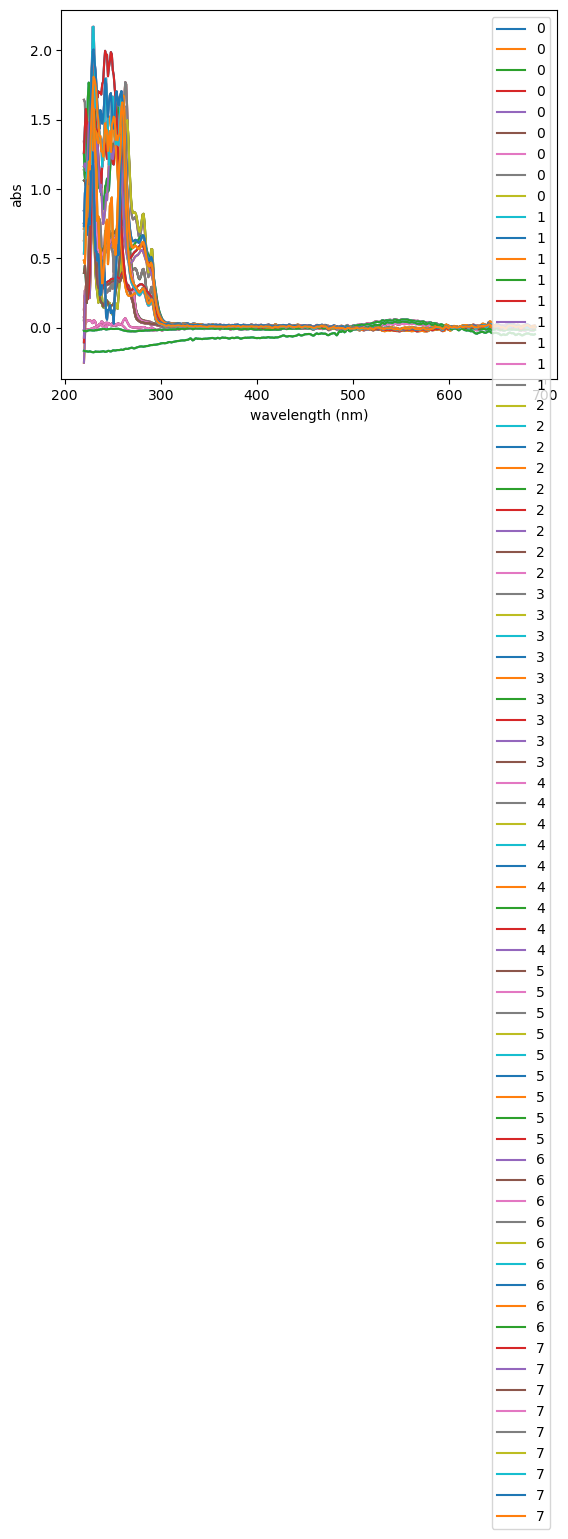

In [32]:
import sys
import pandas as pd, os, glob, numpy as np, time, datetime
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt


def remove_unwanted_columns(df):
    for column in df.columns:
        if 'remove' in column:
            print(column)
            try:
                df = df.drop(columns=[column])
            except:
                print(f"column {column} is not in df or it is already removed")
    return df


def treat_one_file(xml_folder, xml_name,rename = True):
    global df

    xml_folder += '\\'
    xml_path = xml_folder + xml_name
    tree = ET.parse(xml_path)
    workbook = tree.getroot()
    all_spectra, row_index, time_stamps = [], [], []
    # parse xml tree
    for worksheet in workbook[1:]:  ## root = workbook. workbook[0] is Styles
        table = list(worksheet)[0]  # worksheet has one child: table
        rows = list(table)  # table[0], table[1], table[2] are empty, table[3] is column data
        row_dict = {}
        for row in rows[5:]:
            # print(row.tag, row.attrib)
            row_data = list(row)
            wavelength = int(row_data[0][0].text)
            try:
                absorbance = float(row_data[1][0].text)
                row_dict[wavelength] = absorbance
            except ValueError:
                print("The format of the xml is incorrect! Please double check.")

            title = row_data[2][0].text
            if title:
                row_index.append(title)
            if row_data[3][0].text:
                time_here = row_data[3][0].text
                time_stamps.append(time_here)

        all_spectra.append(row_dict)

    assert len(all_spectra) == len(row_index), "wrong data structure of XML file!!"

    # save row_dict to dataframe
    df = pd.DataFrame(all_spectra, index=row_index)
    df = df.T

    # remove unwated columens
    df = remove_unwanted_columns(df=df)

    if rename:
        # change xml file name
        # convert time stamp to unix time
        unix_time = time.mktime(datetime.datetime.strptime(time_stamps[0], "%m/%d/%Y %I:%M:%S %p").timetuple())
        # convert unix time to human readable time
        human_readable_time = datetime.datetime.fromtimestamp(unix_time).strftime('%Y-%m-%d_%H-%M-%S')
        # rename the xml file name using the human readable time
        os.rename(xml_folder + xml_name, human_readable_time + '_' + xml_name)

        column_names = df.columns.values
        uniques, counts = np.unique(column_names, return_counts=True)

        xml_name_new = human_readable_time + '_' + xml_name
        df.to_csv(xml_folder + xml_name_new[:-4] + '.csv')


    # # plot the spectra
    for column in df.columns:
        # print(df[column])
        plt.plot(df.index[30:500], df[column][30:500], label=column)
    plt.legend(loc="upper right")
    plt.xlabel('wavelength (nm)')
    plt.ylabel('abs')
    # labelLines(plt.gca().get_lines(), zorder=2.5)
    plt.show()

    # save plot
    # plt.savefig(xml_folder + xml_name[:-4] + '.png')

    return df


if __name__ == "__main__":
    xml_folder = r'C:\Users\Administrator\Desktop\python-data_analysis\UV-Vis'
    xml_name = '2023_09_14_UV-Vis_1.xml'
    df = treat_one_file(xml_folder = xml_folder, xml_name = xml_name)
